In [50]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path('datasets/housing.tgz')
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [62]:
housing.head()
housing.tail()
housing.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10567 entries, 6027 to 17201
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           10567 non-null  float64
 1   latitude            10567 non-null  float64
 2   housing_median_age  10567 non-null  float64
 3   total_rooms         10567 non-null  float64
 4   total_bedrooms      10453 non-null  float64
 5   population          10567 non-null  float64
 6   households          10567 non-null  float64
 7   median_income       10567 non-null  float64
 8   median_house_value  10567 non-null  float64
 9   ocean_proximity     10567 non-null  object 
dtypes: float64(9), object(1)
memory usage: 908.1+ KB


In [27]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [28]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

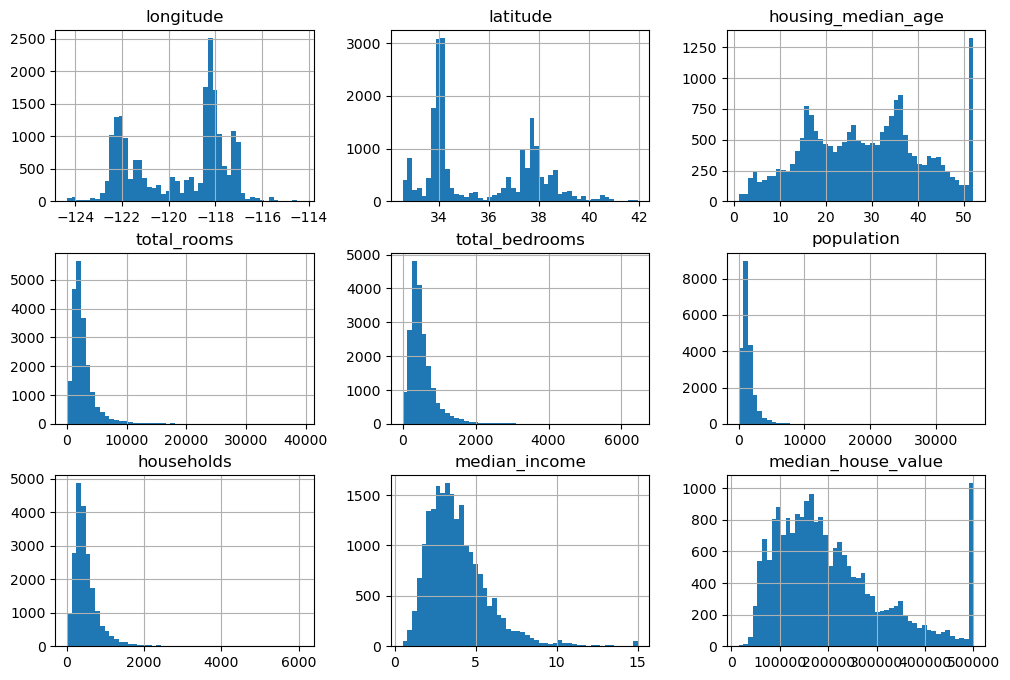

In [29]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12,8))

In [42]:
from zlib import crc32
import numpy as np

## test data

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()

train_set,test_set = split_data_with_id_hash(housing_with_id, 0.2, 'index')

In [44]:
## Creating categories
housing['income_cat'] = pd.cut(housing['median_income'],bins=[0,1.5,3,4.5,6,np.inf], labels=[1,2,3,4,5])

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY,3


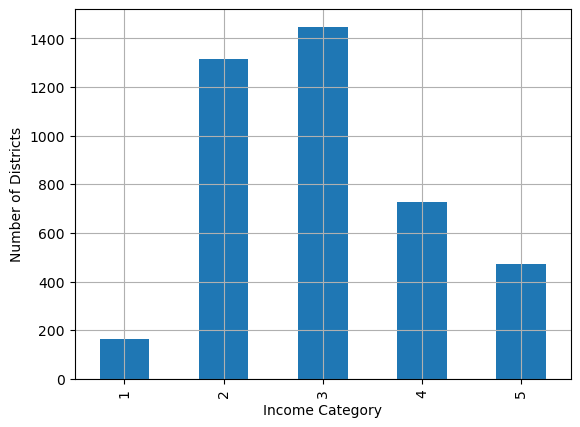

In [45]:
housing['income_cat'].value_counts().sort_index().plot.bar(grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state = 42)

strat_splits = []

for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [47]:
strat_train_set, strat_test_set = strat_splits[0]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

C:\Users\Revanth Mulluri\AppData\Local\Temp\ipykernel_22608\735148781.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
C:\Users\Revanth Mulluri\AppData\Local\Temp\ipykernel_22608\735148781.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)


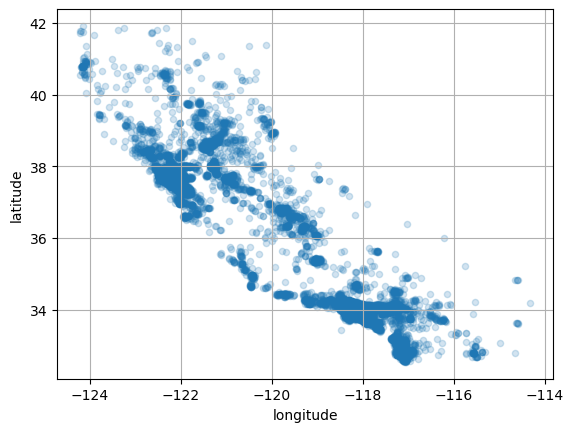

In [53]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,  alpha=0.2)
plt.show()

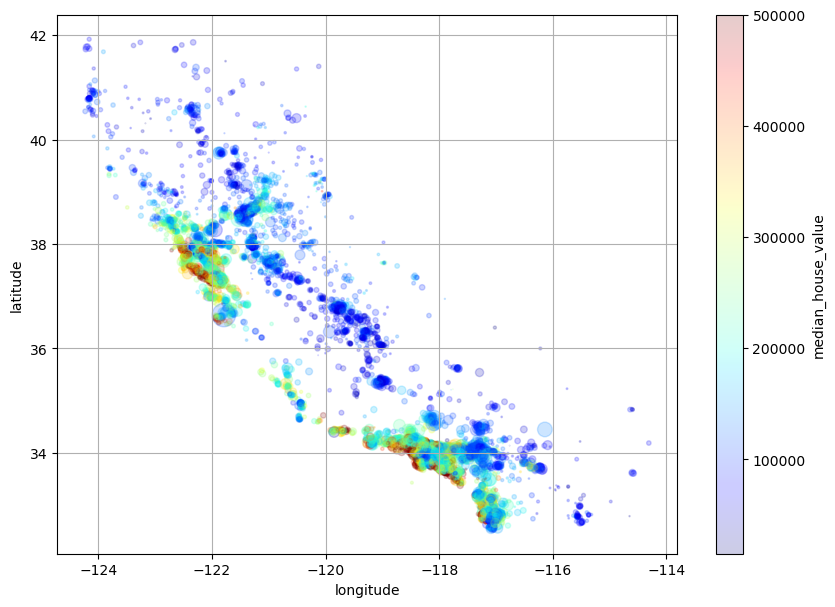

In [55]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,  alpha=0.2, s=housing['population']/100, c='median_house_value', cmap="jet", colorbar=True, legend=True, figsize=(10,7))
plt.show()

In [66]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value']

longitude            -0.046998
latitude             -0.140777
housing_median_age    0.094120
total_rooms           0.139557
total_bedrooms        0.062351
population           -0.018753
households            0.076868
median_income         0.677744
median_house_value    1.000000
Name: median_house_value, dtype: float64